In [ ]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("indeed-job-listings-information.csv")

df.head(3)



,jobid,company_name,date_posted_parsed,job_title,description_text,benefits,job_type,location,salary_formatted,company_rating,...,Column16355,Column16356,Column16357,Column16358,Column16359,Column16360,Column16361,Column16362,Column16363,Column16364
0,d46480488e3aa20c,FitLab INC,"""2024-08-04T14:55:36.532Z""",FitLab Email Marketing Manager,Description: \n Who Is FitLab: FitLab is a p...,"[""401(k)"",""Dental insurance"",""Disability insur...",Full-time,California,"$90,000 - $105,000 a year",4.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ba9bf4e04cfd9cdb,Buccal Up Dental,"""2024-08-04T12:29:09.402Z""",Customer Service Representative - Work From Home,The Customer Associate is the first point of c...,"[""401(k) matching"",""Continuing education credi...",Permanent,"Sugar Land, TX 77479",$28 - $50 an hour,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9e4031d06dd42d32,Peraton,"""2024-08-01T19:30:03.000Z""",Information Technology Support Specialist,About Peraton Peraton is a next-generation na...,"[""Dental insurance"",""Disability insurance"",""He...",Full-time,United States,"$66,000 - $106,000 a year",3.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("Shape:", df.shape)
df.columns


Shape: (1000, 16384)


Index(['jobid', 'company_name', 'date_posted_parsed', 'job_title',
       'description_text', 'benefits', 'job_type', 'location',
       'salary_formatted', 'company_rating',
       ...
       'Column16355', 'Column16356', 'Column16357', 'Column16358',
       'Column16359', 'Column16360', 'Column16361', 'Column16362',
       'Column16363', 'Column16364'],
      dtype='object', length=16384)

In [ ]:
missing_before = df.isnull().sum()
missing_before[missing_before > 0]


,0
Column1,1000
Column2,1000
Column3,1000
Column4,1000
Column5,1000
...,...
Column16360,1000
Column16361,1000
Column16362,1000
Column16363,1000


In [ ]:
use_cols = ['job_title', 'description_text', 'location', 'job_type']

# Keep only columns that exist (safety)
use_cols = [c for c in use_cols if c in df.columns]
jobs = df[use_cols].copy()

print("Using columns:", use_cols)
jobs.head()


Using columns: ['job_title', 'description_text', 'location', 'job_type']


,job_title,description_text,location,job_type
0,FitLab Email Marketing Manager,Description: \n Who Is FitLab: FitLab is a p...,California,Full-time
1,Customer Service Representative - Work From Home,The Customer Associate is the first point of c...,"Sugar Land, TX 77479",Permanent
2,Information Technology Support Specialist,About Peraton Peraton is a next-generation na...,United States,Full-time
3,Opérateur.trice de réservation hotelière (de j...,"Dans ce cadre, vous êtes amené/e à réaliser le...",75012 Paris,CDD
4,Chauffeur Opérateur Curage H/F,Informations générales ...,Wissous (91),"CDI, Temps plein"


In [ ]:
jobs.fillna("", inplace=True)


In [ ]:
jobs.isnull().sum()


,0
job_title,0
description_text,0
location,0
job_type,0
combined_text,0


In [ ]:
jobs = jobs.fillna("")

# combine text fields into one feature for TF-IDF
jobs["combined_text"] = ""
for c in use_cols:
    jobs["combined_text"] += " " + jobs[c].astype(str)

jobs["combined_text"] = jobs["combined_text"].str.replace(r"\s+", " ", regex=True).str.strip()

print("Rows:", len(jobs))
jobs[["combined_text"]].head()


Rows: 1000


,combined_text
0,FitLab Email Marketing Manager Description: Wh...
1,Customer Service Representative - Work From Ho...
2,Information Technology Support Specialist Abou...
3,Opérateur.trice de réservation hotelière (de j...
4,Chauffeur Opérateur Curage H/F Informations gé...


In [ ]:
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(jobs["combined_text"])

print("TF-IDF matrix shape:", tfidf_matrix.shape)


TF-IDF matrix shape: (1000, 5000)


In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Cosine similarity matrix shape:", cosine_sim.shape)


Cosine similarity matrix shape: (1000, 1000)


In [ ]:
def recommend_jobs(job_index, top_n=5):
    scores = list(enumerate(cosine_sim[job_index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)

    top_matches = scores[1:top_n+1]
    indices = [i for i, _ in top_matches]

    result = jobs.iloc[indices][use_cols].copy()
    result["similarity_score"] = [s for _, s in top_matches]

    return result


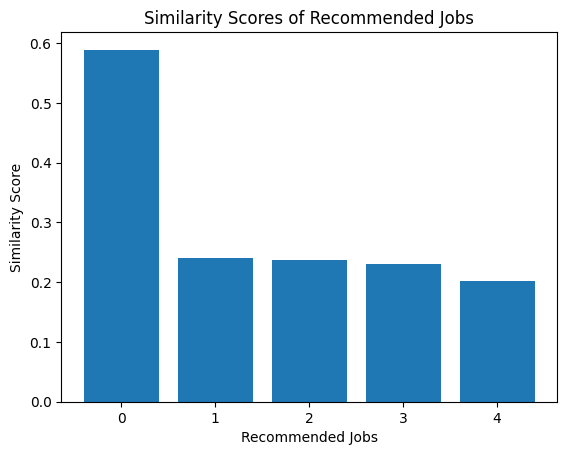

In [ ]:
import matplotlib.pyplot as plt

# Get recommendations
recs = recommend_jobs(test_index, top_n=5)

# Plot similarity scores
plt.figure()
plt.bar(range(len(recs)), recs["similarity_score"])
plt.xlabel("Recommended Jobs")
plt.ylabel("Similarity Score")
plt.title("Similarity Scores of Recommended Jobs")
plt.show()


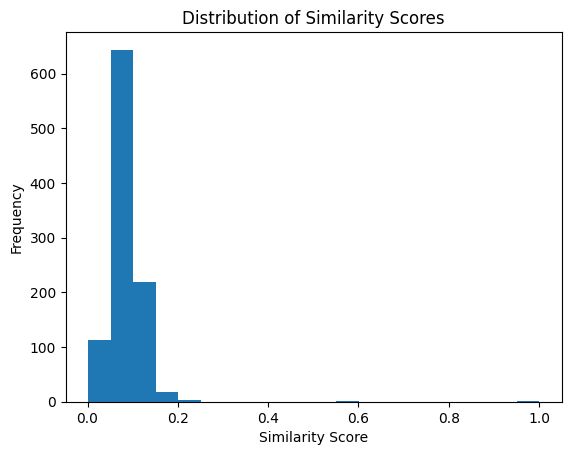

In [ ]:
plt.figure()
plt.hist(cosine_sim[test_index], bins=20)
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(stop_words="english", max_features=5000)
count_matrix = count_vec.fit_transform(jobs["combined_text"])

count_sim = cosine_similarity(count_matrix, count_matrix)


/tmp/ipython-input-2082757081.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([count_scores, tfidf_scores], labels=["Count Vectorizer", "TF-IDF"])


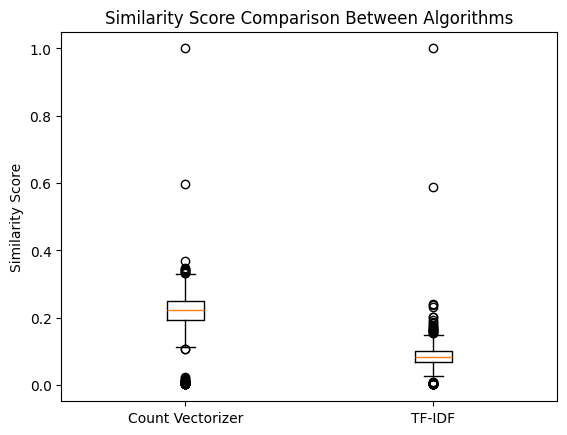

In [ ]:
tfidf_scores = cosine_sim[test_index]
count_scores = count_sim[test_index]

plt.figure()
plt.boxplot([count_scores, tfidf_scores], labels=["Count Vectorizer", "TF-IDF"])
plt.ylabel("Similarity Score")
plt.title("Similarity Score Comparison Between Algorithms")
plt.show()


In [ ]:
test_index = 10

print("Selected Job:")
display(jobs.iloc[[test_index]][use_cols])

print("\nRecommended Jobs:")
recommend_jobs(test_index, top_n=5)


Selected Job:


,job_title,description_text,location,job_type
10,Integrated Marketing Coordinator,At Torrid we're committed to cultivating a wel...,Remote,Full-time



Recommended Jobs:


,job_title,description_text,location,job_type,similarity_score
621,Merchandise Planner - Remote,At Torrid we're committed to cultivating a wel...,United States,Full-time,0.588868
460,"Coordinator, Brand & Planning","Noodle is higher education’s leading strategy,...",Remote,Full-time,0.240012
129,Sales Order Coordinator,"C1 Company Overview: \n C1: 1 Contact, 1 Co...",Remote,Full-time,0.236284
386,Maintenance Renewal Specialist,"C1 Company Overview: \n C1: 1 Contact, 1 Co...",Remote,Full-time,0.230334
608,Ascend Retail Junior Accountant,A bit about us\n Trek is an awesome place...,Remote,Full-time,0.201793
